<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_18/conditional_VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install pytorch-lightning
#! pip install pytorch-lightning-bolts==0.2.5rc1
!pip install --quiet "torchinfo" "lightning-bolts"

# Full Implementation
So, the full implementation is as follows.

In [30]:
import torch
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)


class MNIST_Encoder(nn.Module):
    def __init__(self, input_dim = 784, hidden_dim = 512, encoding_dim=512):
        super().__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.fc_3 = nn.Linear(hidden_dim, encoding_dim, bias=False)

    def forward(self, x):
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = F.relu(self.fc_3(x))
        return x



class MNIST_Decoder(nn.Module):
    def __init__(self, output_dim = 784, hidden_dim = 512, latent_dim=256):
        super().__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim, bias=False)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.fc_3 = nn.Linear(hidden_dim, output_dim, bias=False)


    def forward(self, x):
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = F.relu(self.fc_3(x))
        return x



class ConditionalVAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=28, num_classes=10):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = MNIST_Encoder()
        self.decoder = MNIST_Decoder()
        self.num_classes = num_classes

        # class embeddings
        #self.class_embeddings = nn.Sequential(nn.Linear(num_classes, enc_out_dim),
        #                                      nn.ReLU())
        self.class_embeddings = nn.Embedding(num_classes, enc_out_dim)

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        #print(f"log_pxz: {log_pxz.shape}")
        return log_pxz.sum(dim=1)

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def forward(self,x,label):
        # encode x to get the mu and variance parameters
        #print(x.shape)
        x_encoded = self.encoder(x)

        # Add label embedding to the image embeddings
        c = self.class_embeddings(label)
        #x_encoded = x_encoded + c

        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)
        return x_hat, mu, std, z


    def training_step(self, batch, batch_idx):
        x, label = batch
        x = torch.flatten(x, start_dim=1)

        # get the x_hat
        x_hat, mu, std, z = self(x, label)
        #print(f"x_hat: {x_hat.shape}")
        #print(f"x: {x.shape}")



        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

Let's use MNIST already split up and transformed.

The Lightning Datamodule has 3 dataloaders, train, val, test

In [7]:
from pl_bolts.datamodules import MNISTDataModule

datamodule = MNISTDataModule('.')

**Inference after every 10 epochs**

In [80]:
from matplotlib.pyplot import imshow, figure, show
from torchvision.utils import make_grid
import numpy as np



def generate_images(model, image, label, num_images=32):
    predictions = []
    figure(figsize=(8, 3), dpi=300)
    with torch.no_grad():
        for cnt in range(num_images):
            this_pred,_,_,_ = model(torch.flatten(image, start_dim=1), label)
            this_pred = this_pred.view(1, 28, 28).tile((3,1,1))
            predictions.append(this_pred)
    #predictions_t = torch.tensor(predictions)
    #print(predictions_t.shape)
    print(torch.stack(predictions).shape)
    img = make_grid(torch.stack(predictions).unsqueeze(0)).permute(1,2,3,0)
    print(img.shape)
    # PLOT IMAGES
    imshow(img)
    show()

In [10]:
from pytorch_lightning.callbacks import Callback

class PeriodicInference(Callback):
    def __init__(self, data_module):
        super().__init__()
        self.data_module = data_module
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def on_train_epoch_end(self, trainer, pl_module):
        if (trainer.current_epoch +1) % 1 == 0:
            # plot SAMPLE IMAGES
            test_dl = self.data_module.val_dataloader()
            images, labels = next(iter(test_dl))
            one_image = images[0].unsqueeze(0)
            one_label = labels[0].unsqueeze(0)
            generate_images(trainer.model, one_image.to(self.device), one_label.to(self.device))



Now we train!

In [55]:
pl.seed_everything(1234)

cond_vae = ConditionalVAE()
#trainer = pl.Trainer(gpus=1,
#                     max_epochs=1,
#                     callbacks=[PeriodicInference(data_module=datamodule)])
#trainer.fit(cond_vae, datamodule)

INFO:lightning_fabric.utilities.seed:Global seed set to 1234
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type          | Params
---------------------------------------------------
0 | encoder          | MNIST_Encoder | 925 K 
1 | decoder          | MNIST_Decoder | 794 

Training: 0it [00:00, ?it/s]

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
32


AttributeError: ignored

<Figure size 2400x900 with 0 Axes>

## Plot an image

torch.Size([32, 3, 28, 28])
torch.Size([3, 28, 28, 32])


TypeError: ignored

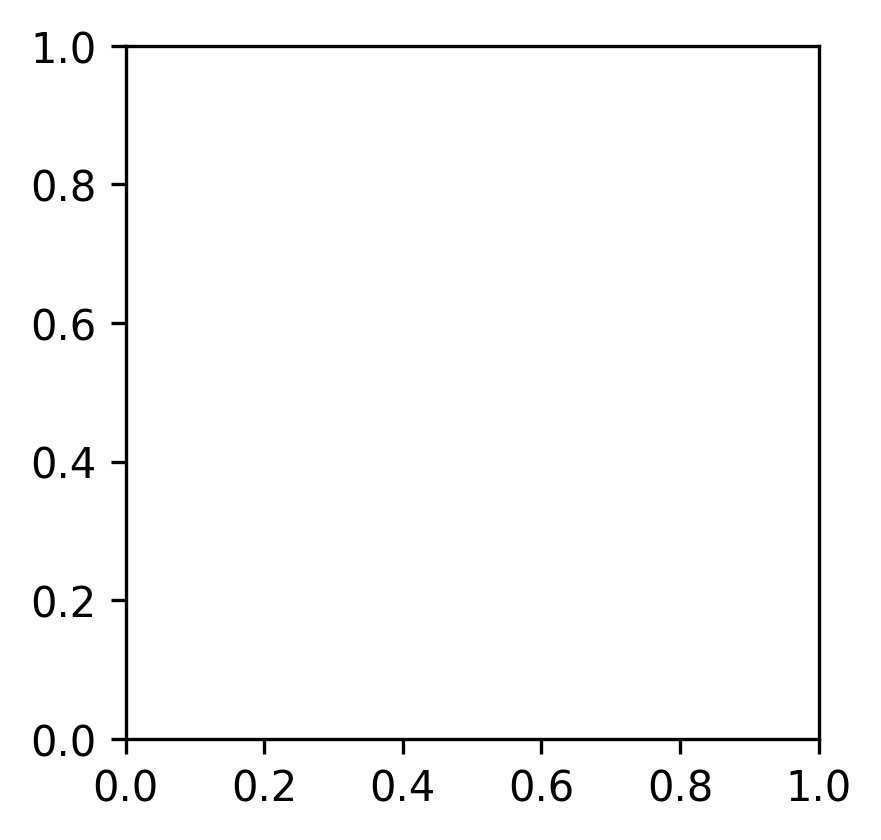

In [81]:
imgs, labels = next(iter(datamodule.val_dataloader()))
one_image = imgs[0].unsqueeze(0)
one_label = labels[0].unsqueeze(0)
generate_images(cond_vae, one_image, one_label, num_images=32)